In [1]:
import cfbd
import numpy as np
import pandas as pd

from api_key import API_KEY
from fastai.tabular import *
from fastai.tabular.all import *

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = API_KEY

api_config = cfbd.ApiClient(configuration)

teams_api = cfbd.TeamsApi(api_config)
ratings_api = cfbd.RatingsApi(api_config)
games_api = cfbd.GamesApi(api_config)
stats_api = cfbd.StatsApi(api_config)
betting_api = cfbd.BettingApi(api_config)

games = []
lines = []

for year in range(2015, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]

    response = betting_api.get_lines(year=year)
    lines = [*lines, *response]

games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]

In [2]:
games = [
    dict(
        id = g.id,
        year = g.season,
        week = g.week,
        neutral_site = g.neutral_site,
        home_team = g.home_team,
        home_conference = g.home_conference,
        home_points = g.home_points,
        home_elo = g.home_pregame_elo,
        away_team = g.away_team,
        away_conference = g.away_conference,
        away_points = g.away_points,
        away_elo = g.away_pregame_elo
    ) for g in games]


In [3]:
for game in games:
    game_lines = [l for l in lines if l.id == game['id']]

    if len(game_lines) > 0:
        game_line = [l for l in game_lines[0].lines if l['provider'] == 'Bovada']

        if len(game_line) > 0 and game_line[0]['spread'] is not None:
            game['spread'] = float(game_line[0]['spread'])
        if len(game_line) > 0 and game_line[0]['overUnder'] is not None:
            game['overUnder'] = float(game_line[0]['overUnder'])

In [5]:
games = [g for g in games if 'spread' in g and g['spread'] is not None]
games = [g for g in games if 'overUnder' in g and g['overUnder'] is not None]

len(games)

1447

In [6]:
for game in games:
    game['margin'] = game['away_points'] - game['home_points']
    game['total'] = game['away_points'] + game['home_points']

In [39]:
df = pd.DataFrame.from_records(games).dropna()
df.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,overUnder,margin,total
0,401112080,2019,10,False,Baylor,Big 12,17,1665,West Virginia,Big 12,14,1530,-18.0,57.0,-3,31
1,401121960,2019,10,False,Appalachian State,Sun Belt,21,1770,Georgia Southern,Sun Belt,24,1396,-14.0,41.5,3,45
2,401117894,2019,10,False,Connecticut,American Athletic,10,996,Navy,American Athletic,56,1599,26.5,55.0,46,66
3,401114300,2019,10,False,Florida International,Conference USA,24,1376,Old Dominion,Conference USA,17,1088,-18.0,47.5,-7,41
4,401112500,2019,10,False,Wake Forest,ACC,44,1565,NC State,ACC,10,1490,-8.5,61.0,-34,54


In [10]:
test_df = df.query("year == 2021")
train_df = df.query("year != 2021")

In [61]:
excluded = ['id','year','week','home_team','away_team','margin', 'total', 'home_points', 'away_points']
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in df.columns.to_list() if c not in cat_features and c not in excluded]

cont_features

['home_elo', 'away_elo', 'spread', 'overUnder']

In [62]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
splits

((#580) [606,646,350,236,630,501,598,636,708,18...],
 (#145) [495,375,724,378,716,288,662,49,645,57...])

In [63]:
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names={"margin", "total"},
                    cat_names = cat_features,
                    cont_names = cont_features,
                   splits=splits)

In [64]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,overUnder,margin,total
0,American Athletic,American Athletic,False,1877.000010,1503.000000,-13.5,57.0,-28.0,48.0
1,Big 12,Sun Belt,False,1632.000003,1427.000002,-15.5,56.0,4.0,66.0
2,American Athletic,American Athletic,False,1298.999998,1587.000004,12.0,72.0,-14.0,90.0
3,Sun Belt,FBS Independents,False,1705.000002,1966.999987,-11.0,53.5,-5.0,39.0
4,American Athletic,American Athletic,False,896.999981,1159.999993,16.0,64.5,7.0,55.0
5,ACC,ACC,False,1538.000000,1561.000001,-3.0,49.5,17.0,37.0
6,FBS Independents,American Athletic,False,1827.999990,1334.999993,-23.5,49.0,-52.0,52.0
7,Big 12,Big 12,False,1610.000004,1634.000000,2.5,52.5,-7.0,51.0
8,Pac-12,Pac-12,False,1550.000000,1510.000000,-3.0,57.5,7.0,43.0
9,Big 12,Big 12,False,1637.000003,1649.999994,-1.0,58.5,-7.0,61.0


In [65]:
learn = tabular_learner(dls, metrics=mae, lr=10e-1)

SuggestedLRs(valley=0.033113110810518265)

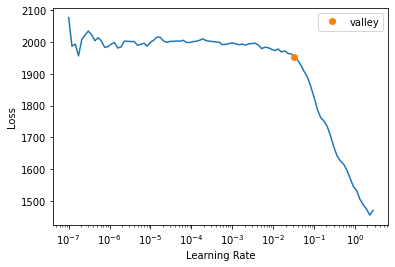

In [66]:
learn.lr_find()

In [67]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(10)

epoch,train_loss,valid_loss,mae,time
0,1311.823730,396.757355,16.106180,00:00
1,817.250671,488.979309,17.630451,00:00
2,621.365967,308.749725,13.747238,00:00
3,511.310852,350.860016,14.994222,00:00
4,441.515350,293.349945,13.643724,00:00
5,394.752289,290.024384,13.658618,00:00
6,360.186646,287.043884,13.486253,00:00
7,335.318054,302.468353,14.117017,00:00
8,319.567902,309.018799,14.039645,00:00
9,307.715912,285.230865,13.502703,00:00


In [68]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(5)

epoch,train_loss,valid_loss,mae,time
0,1316.123413,522.434692,18.492544,00:00
1,821.547546,429.646027,16.635307,00:00
2,625.557800,320.348236,14.011249,00:00
3,514.076660,291.976044,13.703018,00:00
4,446.828461,290.402283,13.570700,00:00


In [79]:
learn.show_results()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,overUnder,margin,total,margin_pred,total_pred
0,11.0,11.0,1.0,-1.102983,-1.147633,0.524095,0.216590,21.0,55.0,3.992881,60.428040
1,2.0,6.0,1.0,0.573839,0.575988,-0.585303,-1.421169,-14.0,34.0,-11.143131,40.986759
2,9.0,9.0,1.0,-0.429806,0.801473,0.810391,-0.147357,13.0,79.0,14.521738,52.263187
3,9.0,9.0,1.0,-0.115657,0.484265,0.595669,-0.996565,24.0,58.0,10.796593,47.663975
4,5.0,5.0,1.0,-0.025900,-0.413852,-0.442155,-1.299854,-5.0,57.0,-4.580053,40.234798
5,1.0,1.0,1.0,0.312728,-0.505575,-0.012711,-1.299854,-18.0,58.0,-5.679539,49.422207
6,1.0,1.0,1.0,-0.070779,-0.054605,-0.155859,0.883825,-14.0,48.0,-6.685176,65.378456
7,8.0,6.0,1.0,-0.621560,0.484265,0.130438,-0.147357,-21.0,83.0,2.971356,48.503162
8,3.0,3.0,1.0,-1.184581,0.446047,1.812429,-0.389988,40.0,54.0,25.245728,58.595078


In [80]:
pdf = test_df.copy()
dl = learn.dls.test_dl(pdf)
#pdf['predicted'] = learn.get_preds(dl=dl)[0].numpy()
pdf.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,overUnder,margin,total
725,401282714,2021,1,False,Illinois,Big Ten,30,1393,Nebraska,Big Ten,22,1503,7.0,52.0,-8,52
726,401286187,2021,1,False,Fresno State,Mountain West,45,1464,Connecticut,American Athletic,0,1223,-28.0,63.5,-45,45
727,401309833,2021,1,False,UCLA,Pac-12,44,1517,Hawai'i,Mountain West,10,1466,-18.0,66.5,-34,54
728,401282049,2021,1,False,New Mexico State,FBS Independents,3,1261,UTEP,Conference USA,30,1222,10.0,59.5,27,33
729,401300995,2021,1,False,UCF,American Athletic,36,1648,Boise State,Mountain West,31,1602,-6.5,67.5,-5,67


In [83]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
pdf.round(1)

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,overUnder,margin,total
725,401282714,2021,1,False,Illinois,Big Ten,30,1393,Nebraska,Big Ten,22,1503,7.0,52.0,-8,52
726,401286187,2021,1,False,Fresno State,Mountain West,45,1464,Connecticut,American Athletic,0,1223,-28.0,63.5,-45,45
727,401309833,2021,1,False,UCLA,Pac-12,44,1517,Hawai'i,Mountain West,10,1466,-18.0,66.5,-34,54
728,401282049,2021,1,False,New Mexico State,FBS Independents,3,1261,UTEP,Conference USA,30,1222,10.0,59.5,27,33
729,401300995,2021,1,False,UCF,American Athletic,36,1648,Boise State,Mountain West,31,1602,-6.5,67.5,-5,67
730,401282607,2021,1,False,NC State,ACC,45,1459,South Florida,American Athletic,0,1251,-20.0,58.0,-45,45
731,401300993,2021,1,False,Appalachian State,Sun Belt,33,1659,East Carolina,American Athletic,19,1403,-9.5,56.0,-14,52
732,401282789,2021,1,False,Minnesota,Big Ten,31,1585,Ohio State,Big Ten,45,1905,14.0,61.5,14,76
733,401281952,2021,1,False,Tennessee,SEC,38,1489,Bowling Green,Mid-American,6,1041,-37.0,60.5,-32,44
734,401309937,2021,1,False,Virginia Tech,ACC,17,1534,North Carolina,ACC,10,1724,6.0,63.5,-7,27


In [84]:
learn.export('cfbd_neural_net')

In [20]:
learn = load_learner('cfbd_neural_net')